In [1]:
import tensorflow as tf
import pandas as pd
import requests
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from src.kube.pod import get_pod_names
from src.prometheus.time_utils import generate_time
from src.prometheus.metrics import metric_labels
from src.prometheus.constants import prometheus_endpoint, prometheus_query, excluding_services

In [5]:
pods = ['vehicles-service', 'customers-service', 'deliveries-service', 'orders-service',
        'availability-service', 'parcels-service']

In [6]:
files = glob.glob("/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/*.csv")
files

['/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/1598877404.csv',
 '/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/1598399688.csv']

In [7]:
datasets = [pd.read_csv(file) for file in files]

In [8]:
dataset = pd.concat(datasets)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(dataset)
dataset = pd.DataFrame(x_scaled, columns=dataset.columns)

In [9]:
cols = [c for c in dataset.columns if c.split('_')[-1] in pods]

In [10]:
dataset = dataset[cols]
dataset = dataset.astype('float32')
dataset.shape

(84420, 54)

In [11]:
batch_size = 420
batches = [(x * batch_size, (x + 1) * batch_size) for x in range(0, int(dataset.shape[0]/420))]

In [12]:
batch_dfs = [dataset.iloc[batch[0]:batch[1]].values for batch in batches]
all_batches = len(batch_dfs)

In [13]:
x_windowed_datasets = []
y_windowed_datasets = []
small_batch_size = 40

for batch_df in batch_dfs:
    for i in range(small_batch_size, batch_df.shape[0] - 1):
        x_windowed_datasets.append(batch_df[i - small_batch_size:i, :-len(pods)])
        y_windowed_datasets.append(batch_df[i+1, -len(pods):])

In [14]:
all_windows = len(x_windowed_datasets)
one_batch_size = int(all_windows / all_batches)

In [15]:
window_size = 20
shift = 5

def extract_windows(window_size, shift):
    iters = int((small_batch_size - window_size) / shift) + 1
    mini_batches = [(i*shift,(i*shift) + window_size) for i in range(iters)]
    windows = np.array([np.arange(m_batch[0], m_batch[1]) for m_batch in mini_batches])
    
    return windows

In [16]:
print(len(x_windowed_datasets))
print(len(y_windowed_datasets))
print(x_windowed_datasets[0].shape)
print(y_windowed_datasets[0].shape)

76179
76179
(40, 48)
(6,)


In [17]:
import random

def extract_subsets(indexes, size):
    mini_batches = [(i * size, (i * size) + size) for i in indexes]
    subsets = np.array([np.arange(int(m_batch[0]), int(m_batch[1])) for m_batch in mini_batches])
    
    return subsets

def train_test_val_split(X, y, split = 0.7, split_val = 0.5):
    all_indexes = range(0, all_batches)
    size = int(all_windows / all_batches)
    
    indexes_train = random.sample(all_indexes, int(split * all_batches))
    indexes_test = list(set(all_indexes) - set(indexes_train))

    indexes_val = random.sample(indexes_test, int(split_val * len(indexes_test)))
    indexes_test = list(set(indexes_test) - set(indexes_val))
    
    X_train = X[extract_subsets(indexes_train, size)]
    y_train = y[extract_subsets(indexes_train, size)]

    X_test = X[extract_subsets(indexes_test, size)]
    y_test = y[extract_subsets(indexes_test, size)]
    
    X_val = X[extract_subsets(indexes_val, size)]
    y_val = y[extract_subsets(indexes_val, size)]
                  
    return X_train, y_train, X_test, y_test, X_val, y_val, len(indexes_train), len(indexes_test), len(indexes_val)

In [18]:
X_train, y_train, X_test, y_test, X_val, y_val, train_len, test_len, val_len = train_test_val_split(np.array(x_windowed_datasets), np.array(y_windowed_datasets))

In [19]:
X_train = X_train.reshape((-1,) + X_train.shape[2:])
y_train = y_train.reshape((-1,) + y_train.shape[2:])

#X_test = X_test.reshape((-1,) + X_test.shape[2:])
#y_test = y_test.reshape((-1,) + y_test.shape[2:])

X_val = X_val.reshape((-1,) + X_val.shape[2:])
y_val = y_val.reshape((-1,) + y_val.shape[2:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(53060, 40, 48)
(53060, 6)
(31, 379, 40, 48)
(31, 379, 6)
(11370, 40, 48)
(11370, 6)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Dense

In [57]:
histories = []

for service_idx in range(0, len(pods)):
    service_metrics = [(len(pods) * x) + service_idx for x in range(0, 8)]
    X_svc_train = X_train[..., service_metrics]
    y_svc_train = y_train[..., service_idx]
    X_svc_test = X_test[..., service_metrics]
    y_svc_test = y_test[..., service_idx]
    X_svc_val = X_val[..., service_metrics]
    y_svc_val = y_val[..., service_idx] 

    model = tf.keras.models.Sequential()
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    history = model.fit(X_svc_train ,y_svc_train, batch_size=int(all_windows / all_batches), validation_data=(X_svc_val, y_svc_val), epochs=20, callbacks=[early_stopping_callback])
    
    histories.append({'model': model, 'X_test': X_svc_test, 'y_test': y_svc_test})

Train on 53060 samples, validate on 11370 samples
Epoch 1/20
53060/53060 [==============================] - 6s 106us/sample - loss: 0.0089 - val_loss: 0.0032
Epoch 2/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0055 - val_loss: 0.0033
Epoch 3/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0046 - val_loss: 0.0024
Epoch 4/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0040 - val_loss: 0.0022
Epoch 5/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0037 - val_loss: 0.0019
Epoch 6/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0035 - val_loss: 0.0019
Epoch 7/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0033 - val_loss: 0.0018
Epoch 8/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0031 - val_loss: 0.0017
Epoch 9/20
53060/53060 [==============================] - 3s 62us/sample - loss: 0.0030 - val

In [58]:
histories[0]['model'].summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               multiple                  70144     
_________________________________________________________________
dropout_79 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_81 (LSTM)               multiple                  49408     
_________________________________________________________________
dropout_80 (Dropout)         multiple                  0         
_________________________________________________________________
dense_42 (Dense)             multiple                  65        
Total params: 119,617
Trainable params: 119,617
Non-trainable params: 0
_________________________________________________________________


In [59]:
import random

sample = random.randint(0, test_len - 1)
sample

21

/home/mfi/anaconda3/envs/TestTensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


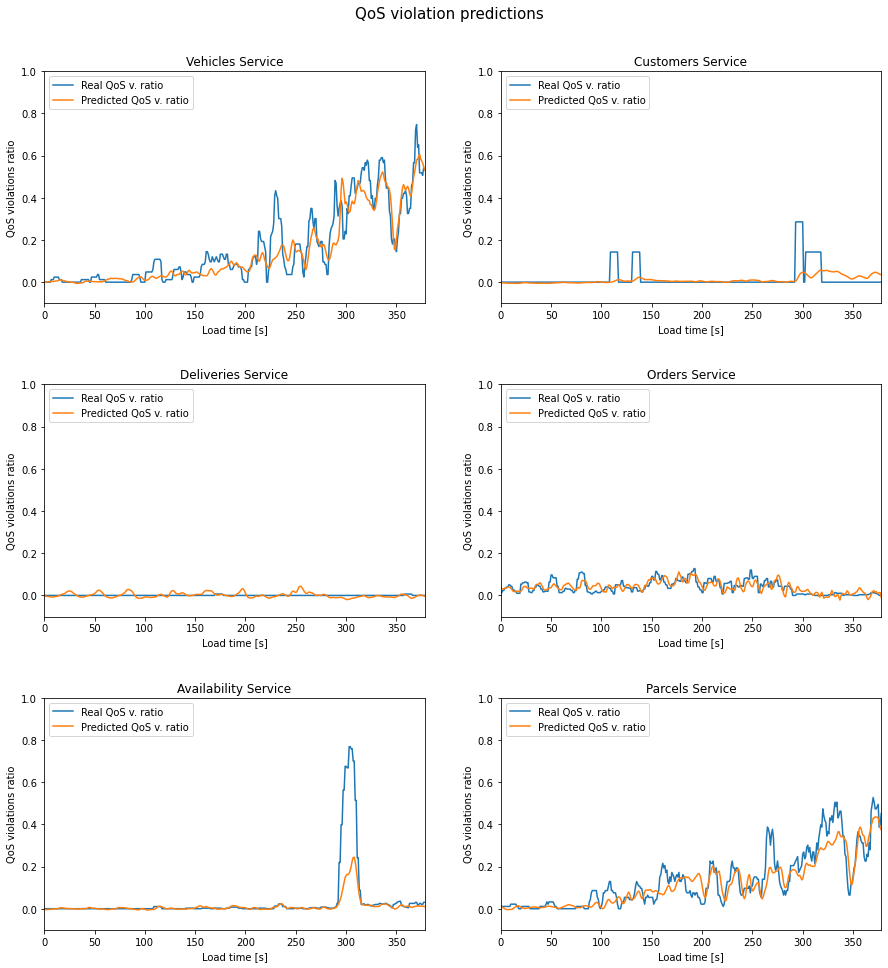

In [60]:
def fancy_service_name(service):
    separated_names = service.split('-')
    for idx, _ in enumerate(separated_names):
        separated_names[idx] = separated_names[idx].capitalize()
    return ' '.join(separated_names)

fig, axs = plt.subplots(int((len(pods)) / 2), 2, figsize=(15, 15), gridspec_kw={'hspace': 0.35})
fig.suptitle(f'QoS violation predictions', fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
x_ax = np.arange(0, int(all_windows / all_batches), 1)
    
for idx in range(0, len(pods)):
    sample_data = histories[idx]
    sample_x = sample_data['X_test'][sample]
    sample_y = sample_data['y_test'][sample]
    prediction = sample_data['model'].predict(sample_x)
    
    ax_data = axs[(int(idx/2), idx%2)]

    ax_data.plot(x_ax, sample_y.reshape(-1, 1))
    ax_data.plot(x_ax, prediction.reshape(-1, 1))
    ax_data.set_xlim([min(x_ax), max(x_ax)])
    ax_data.set_ylim([-0.1, 1.0])
    ax_data.set_xlabel("Load time [s]")
    ax_data.set_ylabel("QoS violations ratio")
    ax_data.set_title(fancy_service_name(pods[idx]))
    ax_data.legend(['Real QoS v. ratio', 'Predicted QoS v. ratio'], loc='upper left')
#plt.savefig('plots/NN/LSTM_one_example.png')

In [61]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

window_score = 15
y_true = []
y_pred = []

for sample in range(0, test_len):
    for pod_idx in range(0, len(pods)):
        sample_data = histories[idx]
        sample_x = sample_data['X_test'][sample]
        sample_y = sample_data['y_test'][sample]
        prediction = sample_data['model'].predict(sample_x)

        unique, counts = np.unique(sample_y, return_counts=True)
        qos_ratios = list(zip(unique, counts))
        small_values = sorted(sorted(list(filter(lambda ratio: ratio[1] > 2, qos_ratios)), key=lambda x: x[1], reverse=True), key=lambda x: x[0])[:2]
        min_ratio = small_values[-1][0] # get most common min ratio (not 0.0 if exixsts)
        
        windows = np.expand_dims(np.arange(window_score), 0) + np.expand_dims(np.arange(one_batch_size - window_score + 1), 0).T
        y_calc_score = sample_y[windows]
        pred_calc_score = prediction[windows]

        all_zeros = np.all(y_calc_score==0)
        if all_zeros:
            min_ratio = 0.1

        min_ratio = min(0.2, min_ratio * 2)
        for y, pred in zip(y_calc_score, pred_calc_score):
            y_qos_exists = np.any(y!=0)
            pred_qos_exists = np.any(pred>=min_ratio)
            y_true.append(y_qos_exists)
            y_pred.append(pred_qos_exists)

prec = int(precision_score(y_true, y_pred) * 100)
f1 = int(f1_score(y_true, y_pred) * 100)
accuracy = int(accuracy_score(y_true, y_pred) * 100)
recall = int(recall_score(y_true, y_pred) * 100)

print(f'{prec}, {accuracy}')

93, 83
